In [32]:
import os
import glob
import pickle
import tqdm
import functools
import multiprocessing
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

import util_figures
import util_localization_psychophysics
import util_localization_psychophysics_figures
import util_spkr_word_psychophysics
import util_spkr_word_psychophysics_figures
import util


In [2]:
list_regex_dir_model = [
    "models/sound_localization/sr20000_IHC3000_delayed_integration/arch??",
    "models/sound_localization/sr20000_IHC3000/arch??",
    "models/sound_localization/IHC3000_delayed_integration/arch??",
    "models/sound_localization/IHC3000/arch??",
    "models/sound_localization/IHC1000/arch??",
    "models/sound_localization/IHC0320/arch??",
    "models/sound_localization/IHC0050/arch??",
    # "models/sound_localization/simplified_IHC3000_delayed_integration/arch??",
    # "models/sound_localization/simplified_IHC3000/arch??",
    # "models/sound_localization/simplified_IHC1000/arch??",
    # "models/sound_localization/simplified_IHC0320/arch??",
    # "models/sound_localization/simplified_IHC0050/arch??",
]

EXPERIMENT_DATAFRAMES = util_localization_psychophysics.run_localization_experiments(
    list_regex_dir_model,
    list_expt=["snr_dependency"],
    workers=20,
    dir_human_data='data/human/sound_localization',
    tag_ckpt='',
    func_label_to_azim_elev=util_localization_psychophysics.label_to_azim_elev,
    key_pred_prob='label_loc_int:probs_out',
    key_pred='label_loc_int:labels_pred',
    key_true='label_loc_int:labels_true',
    n_loc_classes=504,
)


Completed experiment `snr_dependency` for 10 `models/sound_localization/sr20000_IHC3000_delayed_integration/arch??` models
Completed experiment `snr_dependency` for 10 `models/sound_localization/sr20000_IHC3000/arch??` models
Completed experiment `snr_dependency` for 10 `models/sound_localization/IHC3000_delayed_integration/arch??` models
Completed experiment `snr_dependency` for 10 `models/sound_localization/IHC3000/arch??` models
Completed experiment `snr_dependency` for 10 `models/sound_localization/IHC1000/arch??` models
Completed experiment `snr_dependency` for 10 `models/sound_localization/IHC0320/arch??` models
Completed experiment `snr_dependency` for 10 `models/sound_localization/IHC0050/arch??` models


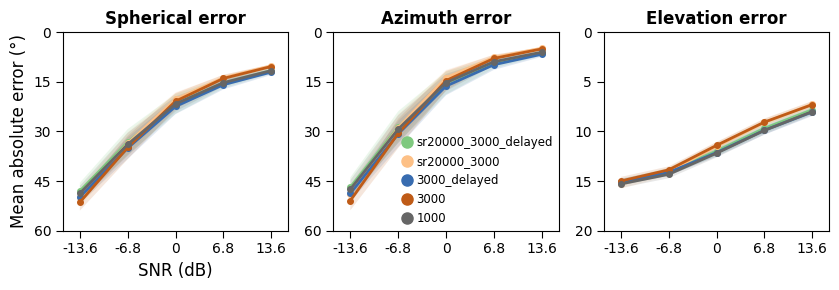

In [45]:
map_k_to_tag_model = {
    'human': "human",
    'sr20000_3000_delayed': "models/sound_localization/sr20000_IHC3000_delayed_integration/arch??",
    'sr20000_3000': "models/sound_localization/sr20000_IHC3000/arch??",
    '3000_delayed': "models/sound_localization/IHC3000_delayed_integration/arch??",
    '3000': "models/sound_localization/IHC3000/arch??",
    '1000': "models/sound_localization/IHC1000/arch??",
    '320': "models/sound_localization/IHC0320/arch??",
    '50': "models/sound_localization/IHC0050/arch??",
}

df_results = EXPERIMENT_DATAFRAMES['snr_dependency']
list_k_model = [
    # 'human',
    'sr20000_3000_delayed',
    'sr20000_3000',
    '3000_delayed',
    '3000',
    '1000',
    # '320',
    # '50',
]
dict_key_metric = {
    'deg_err': {
        'str_title': 'Spherical error',
        'ylimits': [60, 0],
        'yticks': [60, 45, 30, 15, 0],
    },
    'deg_azim_err': {
        'str_title': 'Azimuth error',
        'ylimits': [60, 0],
        'yticks': [60, 45, 30, 15, 0],
    },
    'deg_elev_err': {
        'str_title': 'Elevation error',
        'ylimits': [20, 0],
        'yticks': [20, 15, 10, 5, 0],
    },
}
nrows = 1
ncols = len(dict_key_metric)
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8.5, 3.0))

for itr_ax, key_metric in enumerate(dict_key_metric.keys()):
    ax = ax_arr[itr_ax]
    for itr_model, k_model in enumerate(list_k_model):
        tag_model = map_k_to_tag_model[k_model]
        # color, label = util.get_color_and_label_from_model_tag(tag_model)
        label = k_model
        color = util_figures.get_color_list(5)[itr_model]
        dfi = df_results[np.logical_and.reduce([
            df_results.tag_model == tag_model
        ])]
        if 'pool' in tag_model:
            color = 'orange'
            label = None
        kwargs_format_axes_update = {
            'fontweight_title': 'bold',
            'fontsize_ticks': 10,
            'str_ylabel': 'Mean absolute error (°)' if itr_ax == 0 else None,
            'str_xlabel': 'SNR (dB)' if itr_ax == 0 else None,
        }
        kwargs_format_axes_update.update(dict_key_metric[key_metric])
        kwargs_plot_update = {
            'color': color,
            'label': label,
        }
        ax = util_localization_psychophysics_figures.make_plot_snr_dependency(
            ax,
            dfi,
            key_metric=key_metric,
            kwargs_plot_update=kwargs_plot_update,
            kwargs_format_axes_update=kwargs_format_axes_update)
    if itr_ax == 1:
        kwargs_legend = {
            'loc': 'lower right',
            'borderpad': 0.5,
            'borderaxespad': 0,
            'frameon': False,
            'framealpha': 1.0,
            'facecolor': 'w',
            'edgecolor': 'k',
            'handlelength': 0,
            'markerscale': 2.0,
            'fontsize': 8.5,
        }
        ax.legend(**kwargs_legend)
plt.tight_layout()
plt.show()


In [49]:
def get_p_val(y_null, y):
    """
    Estimate two-tailed p-value of obtaining a value of `y`
    (or more extreme) under the distribution `y_null`
    """
    null_dist = scipy.stats.norm(loc=np.mean(y_null), scale=np.std(y_null))
    p = null_dist.cdf(y)
    if p > 0.5:
        p = 1 - p
    p = p * 2
    return p


df = EXPERIMENT_DATAFRAMES['snr_dependency'].copy()

key_metric = "deg_err"

df = df[np.logical_and.reduce([
    np.isfinite(df.snr),
])]
df = df.groupby(['tag_model']).agg({f'{key_metric}_list': list,}).reset_index()
df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: np.array(_).mean(axis=0))
df[f'{key_metric}'] = df[f'{key_metric}_list'].map(lambda _: np.mean(_))
df[f'{key_metric}_sem'] = df[f'{key_metric}_list'].map(lambda _: np.std(_) / np.sqrt(len(_)))
np.random.seed(0)
df[f'bootstrap_list_{key_metric}'] = df[f'{key_metric}_list'].map(
    lambda _: np.random.choice(_, size=(1000, len(_))).mean(axis=1))

k_ref = "3000"
tag_model_ref = map_k_to_tag_model[k_ref]
for k in list_k_model:
    if not k == k_ref:
        tag_model_cmp = map_k_to_tag_model[k]
        y_null = df[df.tag_model == tag_model_ref].iloc[0][f'bootstrap_list_{key_metric}']
        y_dist = df[df.tag_model == tag_model_cmp].iloc[0][f'bootstrap_list_{key_metric}']
        y_test = df[df.tag_model == tag_model_cmp].iloc[0][f'{key_metric}']
        p_val = get_p_val(y_null, y_test)
        print('Comparing `{}` between `{}` and `{}`: p={:.4f}, cohen_d={:.4f}'.format(
            key_metric,
            k_ref,
            k,
            p_val,
            util.cohend(y_null, y_dist),
        ))


Comparing `deg_err` between `3000` and `sr20000_3000_delayed`: p=0.7511, cohen_d=-0.2352
Comparing `deg_err` between `3000` and `sr20000_3000`: p=0.4245, cohen_d=-0.8172
Comparing `deg_err` between `3000` and `3000_delayed`: p=0.3403, cohen_d=0.9866
Comparing `deg_err` between `3000` and `1000`: p=0.9932, cohen_d=0.0581


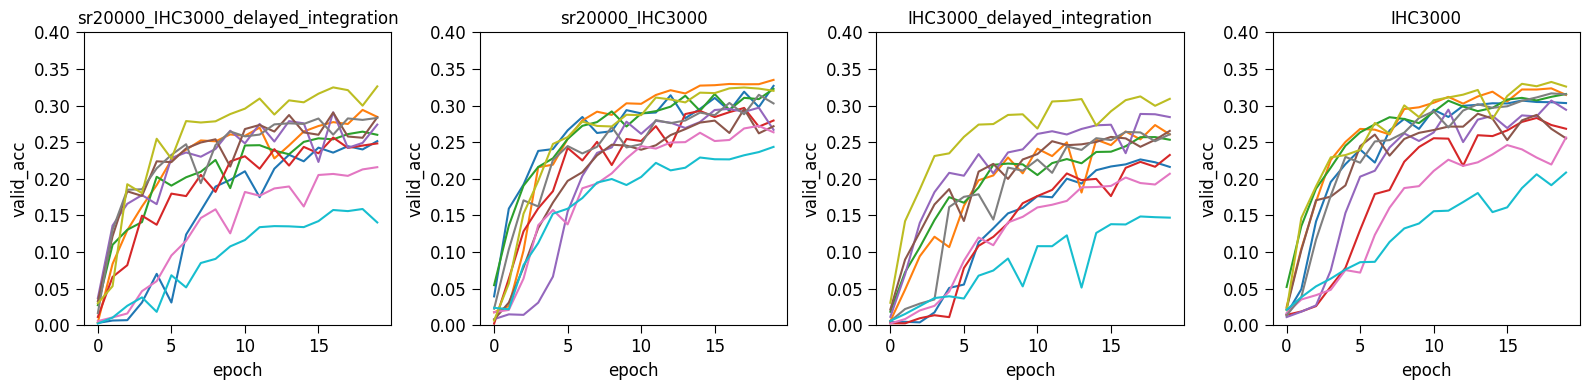

In [47]:
list_tag_model = [
    "sr20000_IHC3000_delayed_integration",
    "sr20000_IHC3000",
    "IHC3000_delayed_integration",
    "IHC3000",
]
fig, ax_arr = plt.subplots(
    nrows=1,
    ncols=len(list_tag_model),
    figsize=(4 * len(list_tag_model), 4),
)
for itr_ax, tag_model in enumerate(list_tag_model):
    list_dir_model = glob.glob(f"models/sound_localization/{tag_model}/arch??")
    for dir_model in list_dir_model:
        df = pd.read_csv(os.path.join(dir_model, "log_optimize.csv"))
        ax_arr[itr_ax].plot(df.epoch, df.val_accuracy)
    util_figures.format_axes(
        ax_arr[itr_ax],
        ylimits=[0, 0.4],
        str_xlabel="epoch",
        str_ylabel="valid_acc",
        str_title=tag_model,
    )
plt.tight_layout()
plt.show()
